In [121]:
#koristeni paketi
import numpy as np
from scipy import linalg as la
from scipy.signal import medfilt
import matplotlib.pyplot as plt
%matplotlib inline

In [122]:
#u ovome bloku koda se definiraju ulazni parametri
L = 2.0 # [m] raspon grede
hh, bb = 0.013, 0.040 # [m] dimencije poprecnog presjeka
IN = bb * hh**3 / 12 # [m^4] momenti inercije
EL = 12.5 * 10**9 # [N/m^2] modul elasticnosti
m_uk = 0.650 * 7/8 + 3 * 0.1 # [kg] ukupna masa
# objasnjenje varijable m_uk: 
#7/8 jer je greda razrezana s 2.40 m na 2.10 m 
#i pribrojnik jer postoje3 dodane mase od 1 N
t = 5 #[sec] proračun se vrši za prvih 5 sekundi
dt=0.000002 #[sec] vremenski korak

In [134]:
#ovdje se vade i rasclanjuju numericki podaci iz eksperimenta
xg = np.fromfile("eksperiment.dat", sep=' ')
xg_vrijeme = xg[0::3] * 0.00625
xg_pomak_stol_B = (xg[2::3] - xg[2]) / 100 # jer su vrijednosti iz datoteke u [cm]
xg_pomak_sredina_grede = (xg[1::3] - xg[1]) / 100 # jer su vrijednosti iz datoteke u [cm]

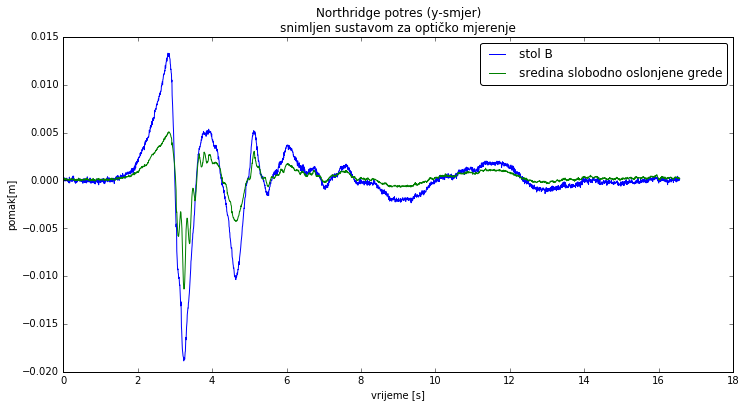

In [137]:
#ispis grafa
fig, axes = plt.subplots(figsize = (12,6))
axes.plot(xg_vrijeme, xg_pomak_stol_B, label="stol B")
axes.plot(xg_vrijeme, xg_pomak_sredina_grede, label="sredina slobodno oslonjene grede")
axes.set_xlabel("vrijeme [s]")
axes.set_ylabel("pomak[m]")
axes.set_title("Northridge potres (y-smjer)"
               "\n"+"snimljen sustavom za optičko mjerenje")
axes.legend(fancybox=True)

In [125]:
#uklanjanje suma iz eksperimentalnih podataka koji su nastali greskama u simulaciji potresa
#i greskama beskontaknog optickog mjerenja
#bez filtera bi sumovi na dobivenim rezultatima bili povecani radi inercijalnih sila
#sustava, još i vise time sto nije implementirano prigusenje koje nije zanemarivo za drvo
#filtriranje prije interpolacije mijenja izmjerene rezultate, ali se pretpostavlja da ih
#mijenja nabolje (uglavnom uklanja greske)
#filter stvarnu vrijednost zamijeni s medijanom stvarne vrijednosti i 6 okolnih vrijednosti
signal_stol_B = medfilt(xg_pomak_stol_B, 7)
signal_sredina_grede = medfilt(xg_pomak_sredina_grede, 7)
#filter na ce na neki nacin oponasati prigusenje (ali nije postupak koji ga moze zamijeniti)

In [126]:
#u ovom bloku koda se duljina zapisa skraćuje na varijablu t te se interpolacijom
#vremenski korak i pripadne vrijednosti svode na definirani vremenski korak dt
vrijeme = np.arange(0,t,dt)
pomak_stol_B = np.interp(vrijeme, xg_vrijeme, signal_stol_B)
pomak_sredina_grede = np.interp(vrijeme, xg_vrijeme, signal_sredina_grede)

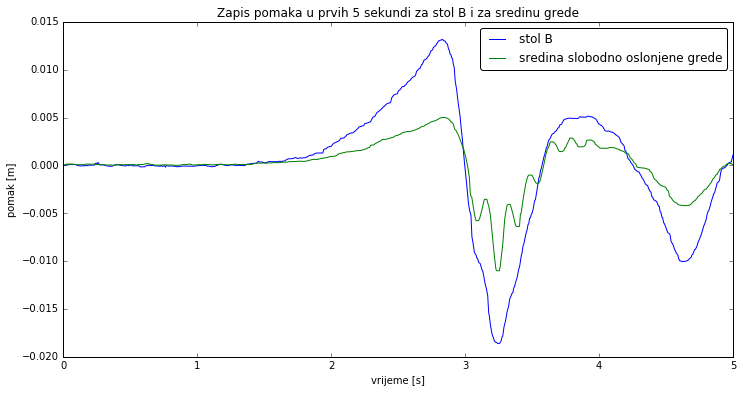

In [127]:
#ispis grafa
fig, axes = plt.subplots(figsize = (12,6))
axes.plot(vrijeme, pomak_stol_B, label="stol B")
axes.plot(vrijeme, pomak_sredina_grede, label="sredina slobodno oslonjene grede")
axes.set_xlabel("vrijeme [s]")
axes.set_ylabel("pomak [m]")
axes.set_title("Zapis pomaka u prvih %s sekundi za stol B i za sredinu grede"%(t))
axes.legend(fancybox=True)

In [132]:
def direktna_integracija_FDM():
    """Kod preuzet od prof. Bicanica te primjenjen na 4 konacna elementa. Vise 
    o metodi se moze naci u literaturi Finite Element Procedures (Bathe)"""
    LN=L/4
    a=12*EL*IN/LN/LN/LN;b=6*EL*IN/LN/LN;c=-a;d=b;
    e=b;f=4*EL*IN/LN;g=-b;h=f/2;
    i=c;j=g;k=a;l=j;
    m=b;n=h;o=j;p=f;
    KK = np.array([[f, g, h, 0, 0, 0, 0, 0],[j, k+a, l+b, c, d, 0, 0, 0],
                   [n, o+e, p+f, g, h, 0, 0, 0],[0, i, j, a+k, b+l,c, d, 0],
                   [0, m, n, e+o, f+p, g, h, 0],[0, 0, 0, i, j, k+a, l+b, 0],
                   [0, 0, 0, m, n, e+o, f+p, h],[0, 0, 0, 0, 0, m, n, p]])
    MM = np.array([[0.001, 0, 0, 0, 0, 0, 0, 0],[0, m_uk/3, 0, 0, 0, 0, 0, 0],
                   [0, 0, 0.001, 0, 0, 0, 0, 0],[0, 0, 0, m_uk/3, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0.001, 0, 0, 0],[0, 0, 0, 0, 0, m_uk/3, 0, 0],
                   [0, 0, 0, 0, 0, 0, 0.001, 0],[0, 0, 0, 0, 0, 0, 0, 0.001]]);
    IMM = dt * dt * np.linalg.inv(MM);
    nn = np.zeros((1,8));
    xmin = nn.T; xcur = nn.T;
    tt, rjesenja = [0], [0]
    for istep in range(1,int(t/dt)): #mozda -1
        tt.append(istep*dt);
        v = 0; vsh = pomak_stol_B[istep];
        ff = np.array([[-e*v, -i*v, -m*v, 0, 0, -c*vsh, -g*vsh, -o*vsh]]);
        rhs = ff.T - 1/dt/dt*MM.dot(xmin) - (KK-2/dt/dt*MM).dot(xcur);
        xnew = IMM.dot(rhs);
        rjesenja.append(xnew[3]);
        #bound(istep)=v;
        xmin=xcur.copy(); xcur=xnew.copy();
    return rjesenja

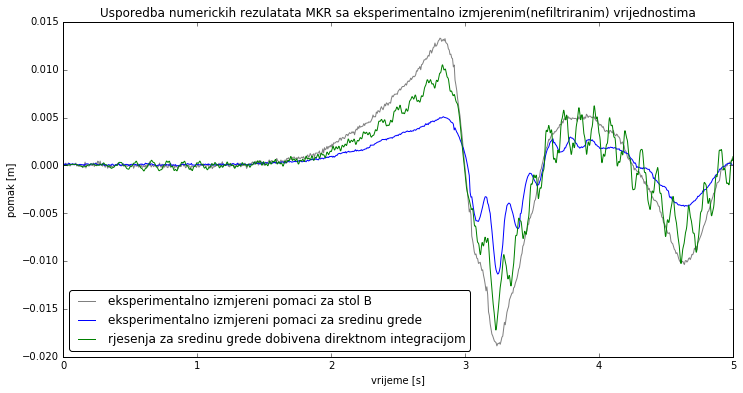

In [143]:
#ispis grafa
stop = int(5/0.00625)
fig, axes = plt.subplots(figsize = (12,6))
axes.plot(xg_vrijeme[:stop], xg_pomak_stol_B[:stop], 
          label="eksperimentalno izmjereni pomaci za stol B",
         color="grey")
axes.plot(xg_vrijeme[:stop], xg_pomak_sredina_grede[:stop], 
          label="eksperimentalno izmjereni pomaci za sredinu grede")
axes.plot(vrijeme, direktna_integracija_FDM(), label="rjesenja za sredinu grede dobivena" + 
          " direktnom integracijom")
axes.set_xlabel("vrijeme [s]")
axes.set_ylabel("pomak [m]")
axes.set_title("Usporedba numerickih rezulatata MKR sa eksperimentalno izmjerenim" 
               +"(nefiltriranim) vrijednostima")
axes.legend(fancybox=True, loc="best")